In [1]:
import tensorflow as tf
import numpy as np
import gym
import time
import matplotlib.pyplot as plt
import pickle
import os

2024-12-20 15:07:43.394099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 15:07:43.399551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 15:07:43.413391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734707263.434556   33940 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734707263.441186   33940 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 15:07:43.464515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
EPISODES = 1500
GAMMA = 0.99
LR = 0.0003
BATCH_SIZE = 256
UPDATE_STEPS = 10
EPSILON = 0.1
VALUE_LOSS_WEIGHT = 0.5
ENTROPY_WEIGHT = 0.01
#reward_threshold = 195
#convergence_window = 100

In [4]:
env = gym.make('CartPole-v1')

In [10]:
model = PPOModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

2024-12-20 15:08:49.552696: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
reward_list = []

if os.path.exists('reward_list.pkl'):
    with open('reward_list.pkl', 'rb') as f:
        reward_list = pickle.load(f)
        print(f"Loaded reward list with {len(reward_list)} episodes.")
        
start_time = time.time()

for episode in range(len(reward_list), EPISODES):
    episode_start_time = time.time()
    
    state = env.reset()[0]
    done = False
    total_reward = 0
    states = []
    actions = []
    rewards = []
    dones = []
    old_log_probs = []
    
    while not done:
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, 0)
        
        logits, value = model(state_tensor)
        prob = tf.nn.softmax(logits)
        
        dist = tf.random.categorical(logits, 1)
        action = dist.numpy()[0][0]
        log_prob = tf.math.log(prob[0, action])
        
        next_state, reward, done, _, _ = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        old_log_probs.append(log_prob)
        
        state = next_state
        total_reward += reward
    
    discounted_rewards = []
    discounted_reward = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        if done:
            discounted_reward = 0
        discounted_reward = reward + GAMMA * discounted_reward
        discounted_rewards.insert(0, discounted_reward)

    states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
    old_values = model(states_tensor)[1]
    advantages = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32) - old_values.numpy().flatten()

    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    old_log_probs = tf.convert_to_tensor(old_log_probs, dtype=tf.float32)
    discounted_rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)
    advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)

    with tf.GradientTape() as tape:
        logits, value = model(states_tensor)
        prob = tf.nn.softmax(logits)
        dist = tf.random.categorical(logits, 1)
        log_prob = tf.math.log(tf.gather(prob, actions, axis=1, batch_dims=1))

        ratio = tf.exp(log_prob - old_log_probs)
        clipped_ratio = tf.clip_by_value(ratio, 1 - EPSILON, 1 + EPSILON)

        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
        value_loss = tf.reduce_mean(tf.square(discounted_rewards - value))
        entropy_loss = -tf.reduce_mean(prob * tf.math.log(prob))

        loss = policy_loss + VALUE_LOSS_WEIGHT * value_loss - ENTROPY_WEIGHT * entropy_loss

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    with open('reward_list.pkl', 'wb') as f:
            pickle.dump(reward_list, f)

    if episode % 10 == 0:
        episode_end_time = time.time()
        elapsed_time = episode_end_time - episode_start_time
        print(f"Episode {episode}, Total Reward: {total_reward}, Time: {elapsed_time:.2f} seconds")

    reward_list.append(total_reward)
    
    #if episode >= convergence_window and np.mean(reward_list[-convergence_window:]) >= reward_threshold:
    #    print(f"Converged at episode {episode}, Average Reward: {np.mean(reward_list[-convergence_window:]):.2f}")
    #    break

end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")



/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: 16.0, Time: 0.00 seconds
Episode 10, Total Reward: 11.0, Time: 0.45 seconds
Episode 20, Total Reward: 10.0, Time: 0.42 seconds
Episode 30, Total Reward: 13.0, Time: 0.54 seconds
Episode 40, Total Reward: 25.0, Time: 1.04 seconds
Episode 50, Total Reward: 13.0, Time: 0.56 seconds
Episode 60, Total Reward: 18.0, Time: 0.75 seconds
Episode 70, Total Reward: 17.0, Time: 0.70 seconds
Episode 80, Total Reward: 19.0, Time: 0.79 seconds
Episode 90, Total Reward: 14.0, Time: 0.60 seconds
Episode 100, Total Reward: 22.0, Time: 0.91 seconds
Episode 110, Total Reward: 12.0, Time: 0.50 seconds
Episode 120, Total Reward: 9.0, Time: 0.39 seconds
Episode 130, Total Reward: 18.0, Time: 0.76 seconds
Episode 140, Total Reward: 12.0, Time: 0.51 seconds
Episode 150, Total Reward: 14.0, Time: 0.59 seconds
Episode 160, Total Reward: 14.0, Time: 0.58 seconds
Episode 170, Total Reward: 9.0, Time: 0.39 seconds
Episode 180, Total Reward: 13.0, Time: 0.55 seconds
Episode 190, Total Reward

Loaded reward list with 1033 episodes.


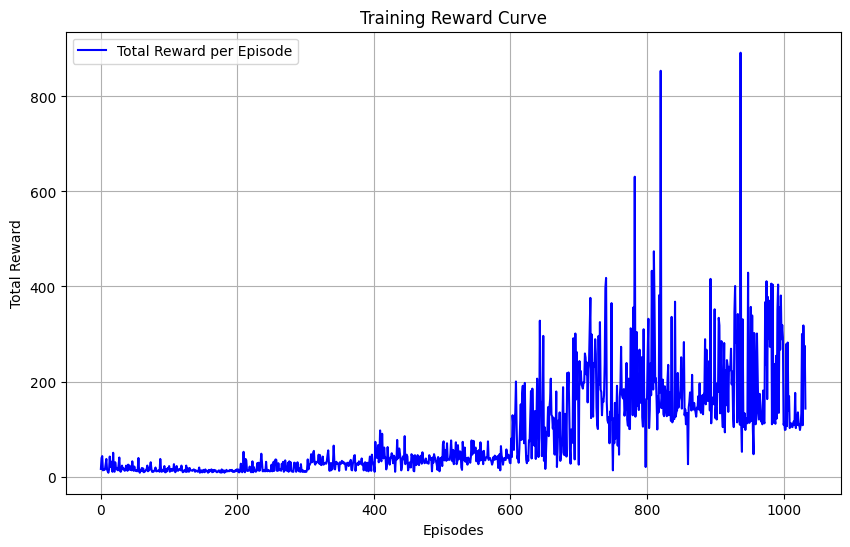

In [2]:
saved_reward_list = []
if os.path.exists('reward_list.pkl'):
    with open('reward_list.pkl', 'rb') as f:
        saved_reward_list = pickle.load(f)
        print(f"Loaded reward list with {len(saved_reward_list)} episodes.")

full_reward_list = saved_reward_list# + reward_list[len(saved_reward_list):]

plt.figure(figsize=(10, 6))
plt.plot(full_reward_list, label='Total Reward per Episode', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training Reward Curve')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
reward_list = []

if os.path.exists('reward_list.pkl'):
    with open('reward_list.pkl', 'rb') as f:
        reward_list = pickle.load(f)
        print(f"Loaded reward list with {len(reward_list)} episodes.")
        
start_time = time.time()

for episode in range(len(reward_list), EPISODES):
    episode_start_time = time.time()
    
    state = env.reset()[0]
    done = False
    total_reward = 0
    states = []
    actions = []
    rewards = []
    dones = []
    old_log_probs = []
    
    while not done:
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, 0)
        
        logits, value = model(state_tensor)
        prob = tf.nn.softmax(logits)
        
        dist = tf.random.categorical(logits, 1)
        action = dist.numpy()[0][0]
        log_prob = tf.math.log(prob[0, action])
        
        next_state, reward, done, _, _ = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        old_log_probs.append(log_prob)
        
        state = next_state
        total_reward += reward
    
    discounted_rewards = []
    discounted_reward = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        if done:
            discounted_reward = 0
        discounted_reward = reward + GAMMA * discounted_reward
        discounted_rewards.insert(0, discounted_reward)

    states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
    old_values = model(states_tensor)[1]
    advantages = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32) - old_values.numpy().flatten()

    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    old_log_probs = tf.convert_to_tensor(old_log_probs, dtype=tf.float32)
    discounted_rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)
    advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)

    with tf.GradientTape() as tape:
        logits, value = model(states_tensor)
        prob = tf.nn.softmax(logits)
        dist = tf.random.categorical(logits, 1)
        log_prob = tf.math.log(tf.gather(prob, actions, axis=1, batch_dims=1))

        ratio = tf.exp(log_prob - old_log_probs)
        clipped_ratio = tf.clip_by_value(ratio, 1 - EPSILON, 1 + EPSILON)

        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
        value_loss = tf.reduce_mean(tf.square(discounted_rewards - value))
        entropy_loss = -tf.reduce_mean(prob * tf.math.log(prob))

        loss = policy_loss + VALUE_LOSS_WEIGHT * value_loss - ENTROPY_WEIGHT * entropy_loss

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    with open('reward_list.pkl', 'wb') as f:
            pickle.dump(reward_list, f)

    if episode % 10 == 0:
        episode_end_time = time.time()
        elapsed_time = episode_end_time - episode_start_time
        print(f"Episode {episode}, Total Reward: {total_reward}, Time: {elapsed_time:.2f} seconds")

    reward_list.append(total_reward)
    
    #if episode >= convergence_window and np.mean(reward_list[-convergence_window:]) >= reward_threshold:
    #    print(f"Converged at episode {episode}, Average Reward: {np.mean(reward_list[-convergence_window:]):.2f}")
    #    break

end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")



Loaded reward list with 1033 episodes.


/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1040, Total Reward: 14.0, Time: 0.58 seconds
Episode 1050, Total Reward: 15.0, Time: 0.63 seconds
Episode 1060, Total Reward: 14.0, Time: 0.57 seconds
Episode 1070, Total Reward: 9.0, Time: 0.38 seconds
Episode 1080, Total Reward: 12.0, Time: 0.52 seconds
Episode 1090, Total Reward: 29.0, Time: 1.21 seconds
Episode 1100, Total Reward: 22.0, Time: 0.93 seconds
Episode 1110, Total Reward: 9.0, Time: 0.39 seconds
Episode 1120, Total Reward: 24.0, Time: 1.01 seconds
Episode 1130, Total Reward: 18.0, Time: 0.77 seconds
Episode 1140, Total Reward: 14.0, Time: 0.58 seconds
Episode 1150, Total Reward: 10.0, Time: 0.42 seconds
Episode 1160, Total Reward: 12.0, Time: 0.50 seconds
Episode 1170, Total Reward: 10.0, Time: 0.43 seconds
Episode 1180, Total Reward: 13.0, Time: 0.56 seconds
Episode 1190, Total Reward: 10.0, Time: 0.43 seconds
Episode 1200, Total Reward: 17.0, Time: 0.72 seconds
Episode 1210, Total Reward: 15.0, Time: 0.64 seconds
Episode 1220, Total Reward: 21.0, Time: 0.87 sec

Loaded reward list with 1500 episodes.


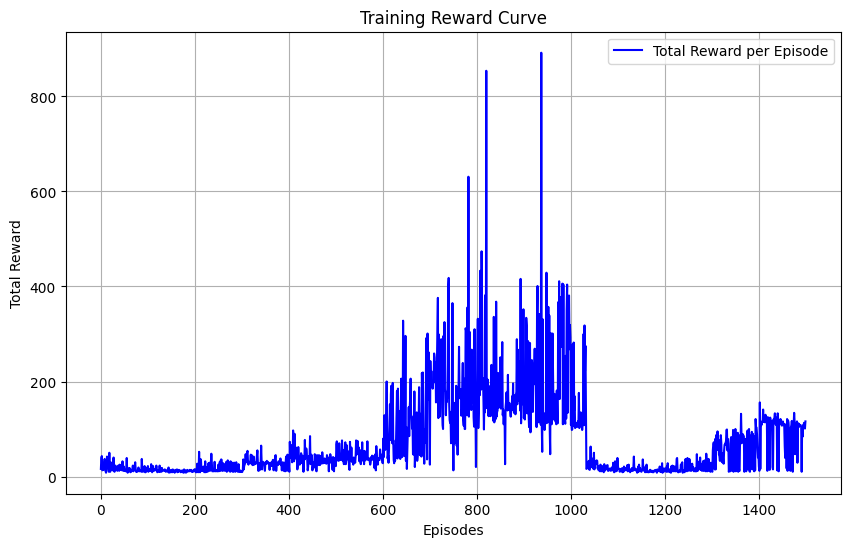

In [12]:
saved_reward_list = []
if os.path.exists('reward_list.pkl'):
    with open('reward_list.pkl', 'rb') as f:
        saved_reward_list = pickle.load(f)
        print(f"Loaded reward list with {len(saved_reward_list)} episodes.")

full_reward_list = saved_reward_list# + reward_list[len(saved_reward_list):]

plt.figure(figsize=(10, 6))
plt.plot(full_reward_list, label='Total Reward per Episode', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training Reward Curve')
plt.legend()
plt.grid(True)
plt.show()